# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Цели по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

- Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
- Проанализируйте скорость работы и качество моделей.
Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:

## Описание данных

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

import lightgbm as lgb

import optuna
import time

STATE = 12345

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=[12])
except:
    df = pd.read_csv(r'C:\Users\EliteBook\Downloads\autos.csv', parse_dates=[12])
df['DateCreated'] = df['DateCreated'].dt.month
display(df.info(), df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  int64 
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(8), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,3,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,3,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,3,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,3,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,3,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,4,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,4,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,3,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,4,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,3,0,27472,2016-03-31 17:17:06


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b> 
    
Молодец, что не забываешь использовать конструкцию try... except...
</div>

In [4]:
# Удалим столбцы, которые по логике задачи не влияют на предсказания стоимости автомобиля
df=df.drop(columns=['DateCrawled','NumberOfPictures','PostalCode', 'LastSeen'],axis=1)

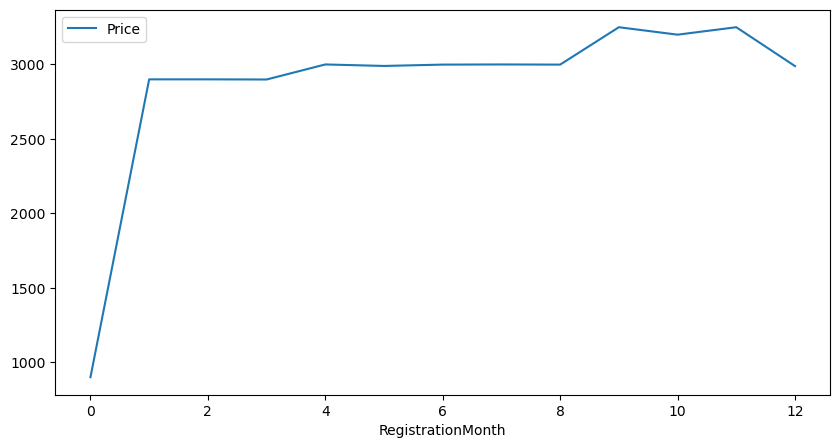

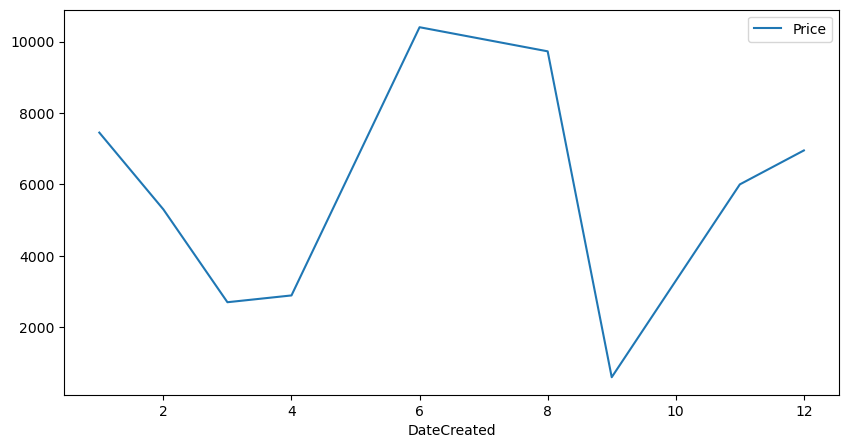

In [5]:
# Изменения кода
# Посмотрим на годовые тренды
df.groupby('RegistrationMonth')['Price'].median().plot(figsize=(10,5), xlabel='RegistrationMonth', legend=True)
plt.show()
df.groupby('DateCreated')['Price'].median().plot(figsize=(10,5), xlabel='DateCreated', legend=True)
plt.show()

In [7]:
# Удалим выбросы вне квантилей 0.015 - 0.985
# Изменения кода
quantile= df.quantile([0.015, 0.985]).reset_index(drop=True)
df.loc[df['Power']<=quantile.loc[0,'Power'],['Power']] = np.nan #df['Power'].median()
df.loc[df['Power']>=quantile.loc[1,'Power'],['Power']] = np.nan #df['Power'].median()
df.loc[df['RegistrationYear']<=quantile.loc[0,'RegistrationYear'],['RegistrationYear']] = np.nan #df['RegistrationYear'].median()
df.loc[df['RegistrationYear']>=quantile.loc[1,'RegistrationYear'],['RegistrationYear']] = np.nan #df['RegistrationYear'].median()

df['Repaired'] = df['Repaired'].fillna('unknow')
df['Model'] = df['Model'].fillna('other')

# Изменения кода
#df=df.dropna(axis=0).reset_index(drop=True)
def fillna_most_count(data, groupped, columns):
    group = data[groupped].unique().tolist()
    for gr in group:
        for col in columns:
            value = data.loc[data[groupped] == gr, col].value_counts(dropna=False).index[0]
            data.loc[data[groupped] == gr, col] = data.loc[data[groupped] == gr, col].fillna(value=value)
    return data

df = fillna_most_count(df, 'Model',columns=['VehicleType','Gearbox','FuelType'])
df=df.dropna(axis=0).reset_index(drop=True)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273278 entries, 0 to 273277
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              273278 non-null  int64  
 1   VehicleType        273278 non-null  object 
 2   RegistrationYear   273278 non-null  float64
 3   Gearbox            273278 non-null  object 
 4   Power              273278 non-null  float64
 5   Model              273278 non-null  object 
 6   Kilometer          273278 non-null  int64  
 7   RegistrationMonth  273278 non-null  int64  
 8   FuelType           273278 non-null  object 
 9   Brand              273278 non-null  object 
 10  Repaired           273278 non-null  object 
 11  DateCreated        273278 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 25.0+ MB
None


In [8]:
# Разделим данные на признаки и таргет
# Отфильтруем категориальные признаки и переведем в числа методом OrdinalEncoder

features = df.drop('Price',axis= 1)
target = df['Price']

#features_num = features.select_dtypes(['int64','float64'])
#features_cat = features.select_dtypes('object').astype('category')

#ordinal = OrdinalEncoder()
#features_cat = pd.DataFrame(ordinal.fit_transform(features_cat),columns=features_cat.columns.tolist())

#features = features_num.join(features_cat, on=features_cat.index) # Соединим категориальные и числовые колонки обратно в общуюю таблицу
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273278 entries, 0 to 273277
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        273278 non-null  object 
 1   RegistrationYear   273278 non-null  float64
 2   Gearbox            273278 non-null  object 
 3   Power              273278 non-null  float64
 4   Model              273278 non-null  object 
 5   Kilometer          273278 non-null  int64  
 6   RegistrationMonth  273278 non-null  int64  
 7   FuelType           273278 non-null  object 
 8   Brand              273278 non-null  object 
 9   Repaired           273278 non-null  object 
 10  DateCreated        273278 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 22.9+ MB


<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b> 
    
Вижу, хорошо.
</div>

## Обучение моделей

### Общee

In [9]:
def rmse(target,preds):
    return mean_squared_error(target, preds, squared=False)
optuna.logging.set_verbosity(optuna.logging.ERROR)
# Изменения кода
# Выделяем валидационный сет из обучающего набора данных
#X_train, X_vt, y_train, y_vt = train_test_split(features, target, test_size=0.4, random_state=STATE)
#X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.2, random_state=STATE)

### LiteGBM + Optuna

In [10]:
features_num = features.select_dtypes(['int64','float64'])
features_cat = features.select_dtypes('object').astype('category')
features = features_num.join(features_cat, on=features_cat.index) # Соединим категориальные и числовые колонки обратно в общуюю таблицу

X_train, X_vt, y_train, y_vt = train_test_split(features, target, test_size=0.4, random_state=STATE)
X_valid, X_test_1, y_valid, y_test_1 = train_test_split(X_vt, y_vt, test_size=0.2, random_state=STATE)

In [11]:
def objective(trial, data=features, target=target):
    feat_cat = features.select_dtypes('category').columns.tolist()
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=STATE-125)
    # Выберем параметры, которые будем подбирать для модели, и запишем в переменную
    # Изменения кода
    params = {
        'metric': 'rmse', 
        'random_state': STATE,
        #'n_estimators' : 2000,
        'learning_rate': trial.suggest_categorical('learning_rate', 
                                                   [0.005,0.006,0.008,0.01,0.015,0.02,0.03]),
        'max_depth': trial.suggest_categorical('max_depth', [-1,10,15,20]),
        'num_leaves' : 63
    }
    
    model = lgb.LGBMRegressor(**params)
    callbacks = [lgb.early_stopping(300, verbose=0), lgb.log_evaluation(period=0)] # Контроль переобучения
    
    # Обучаем модель      
    model.fit(X_train, y_train, eval_set=[(X_test,y_test)], callbacks=callbacks)
    preds = model.predict(X_test)
    
    #метрика RMSE
    metric = rmse(y_test, preds)
    
    return metric


In [12]:
# Создаем задание для фреймворка
t0=time.perf_counter()
study_1 = optuna.create_study(direction='minimize')  # Минимизируем ошибку
study_1.optimize(objective, n_trials=5)              # Количество итераций = 5
t1=time.perf_counter()
optuna_params = study_1.best_params                  # Сохраняем подобранные параметры

optuna_params['metric'] = 'rmse'                     # Добавляем метрику
optuna_params['random_state'] = STATE
optuna_params['n_estimators'] = 1000
optuna_params['reg_alpha'] = 0.09284842371017403,    # Подобрано через Optuna
optuna_params['reg_lambda'] = 0.00251895685091536,   # Подобрано через Optuna
optuna_params['subsample'] = 0.7                     # Подобрано через Optuna
optuna_params['num_leaves'] = 63                     # Подобрано через Optuna

# Создаем и обучаем модель с подобранными гиперпараметрами

model_lgbm_optuna = lgb.LGBMRegressor(**optuna_params)
callbacks = [lgb.early_stopping(300, verbose=0), lgb.log_evaluation(period=0)]
model_lgbm_optuna.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=callbacks)
t2=time.perf_counter()
# Cоздаем предсказание и проверяем метрику
pred_optuna = model_lgbm_optuna.predict(X_valid)
result=rmse(y_valid, pred_optuna)
t3=time.perf_counter()

#print(f'''Model: LiteGBMRegressor
#Time for parametrs optimization: {t1-t0}
#Time for learning model: {t2-t1}
#Time for predicted model:{t3-t2}
#All hte time model is running: {t3-t0}
#RMSE predictions: {result}
#''')

# Изменение кода
# Преворк для сравнения моделей



#study_1.best_params

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\s

In [13]:
mt1 = t1-t0
mt2 = t2-t1
mt3 = t3-t2
r1 = result

### RandomForestRegressor+ Optuna

In [14]:
features = df.drop('Price',axis= 1)
target = df['Price']

features_num = features.select_dtypes(['int64','float64'])
features_cat = features.select_dtypes('object').astype('category')

ordinal = OrdinalEncoder()
features_cat = pd.DataFrame(ordinal.fit_transform(features_cat),columns=features_cat.columns.tolist())

features = features_num.join(features_cat, on=features_cat.index) # Соединим категориальные и числовые колонки обратно в общуюю 

X_train, X_vt, y_train, y_vt = train_test_split(features, target, test_size=0.4, random_state=STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.2, random_state=STATE)

In [15]:
def objective(trial, data=features, target=target):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=STATE-125)
    # Выберем параметры, которые будем подбирать для модели, и запишем в переменную
    params = {
        'random_state': STATE,
        'n_estimators': 500,
        'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt']),
        'max_depth': trial.suggest_categorical('max_depth', [3,5,7,9,11,13,15,17,19])
    }
    
    model = RandomForestRegressor(**params, verbose=0, n_jobs=-1)
    
    # Обучаем модель      
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    #метрика RMSE
    metric = rmse(y_test, preds)
    
    return metric


In [16]:
# Создаем задание для фреймворка
t0=time.perf_counter()

study_2 = optuna.create_study(direction='minimize')  # Минимизируем ошибку
study_2.optimize(objective, n_trials=5)              # Количество итераций = 5

t1=time.perf_counter()
optuna_params_2 = study_2.best_params                # Сохраняем подобранные параметры
                
optuna_params_2['random_state'] = STATE
optuna_params_2['n_estimators'] = 500
optuna_params_2['min_samples_split'] = 14            # Подобрано через Optuna
optuna_params_2['min_samples_leaf'] = 5              # Подобрано через Optuna

# Создаем и обучаем модель с подобранными гиперпараметрами
model_rf_optuna = RandomForestRegressor(**optuna_params_2,  n_jobs=-1)
model_rf_optuna.fit(X_train, y_train)

t2=time.perf_counter()

# Cоздаем предсказание и проверяем метрику
pred_optuna = model_rf_optuna.predict(X_valid)
result = rmse(y_valid, pred_optuna)

t3=time.perf_counter()

#print(f'''Model: RandomForestRegressor
#Time for parametrs optimization: {t1-t0}
#Time for learning model: {t2-t1}
#Time for predicted model:{t3-t2}
#All hte time model is running: {t3-t0}
#RMSE predictions: {result}
#''')

# Изменение кода
# Преворк для сравнения моделей



In [17]:
mt12 = t1-t0
mt22 = t2-t1
mt32 = t3-t2
r2 = result

### LinearRegression

In [18]:
# Разделим данные на признаки и таргет
# Отфильтруем категориальные признаки и переведем в числа методом OrdinalEncoder

features = df.drop('Price',axis= 1)
target = df['Price']

le = LabelEncoder()
features['Model'] = le.fit_transform(features['Model'])

features_num = features.select_dtypes(['int64','float64'])
features_cat = features.select_dtypes('object')

features_cat = pd.get_dummies(features_cat, drop_first=True).astype('int32')

features = features_num.join(features_cat, on=features_cat.index) # Соединим категориальные и числовые колонки обратно в общуюю таблицу
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273278 entries, 0 to 273277
Data columns (total 60 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   RegistrationYear         273278 non-null  float64
 1   Power                    273278 non-null  float64
 2   Kilometer                273278 non-null  int64  
 3   RegistrationMonth        273278 non-null  int64  
 4   DateCreated              273278 non-null  int64  
 5   VehicleType_convertible  273278 non-null  int32  
 6   VehicleType_coupe        273278 non-null  int32  
 7   VehicleType_other        273278 non-null  int32  
 8   VehicleType_sedan        273278 non-null  int32  
 9   VehicleType_small        273278 non-null  int32  
 10  VehicleType_suv          273278 non-null  int32  
 11  VehicleType_wagon        273278 non-null  int32  
 12  Gearbox_manual           273278 non-null  int32  
 13  FuelType_electric        273278 non-null  int32  
 14  Fuel

In [19]:
# Создаем и обучаем модель с подобранными гиперпараметрами
t0=time.perf_counter()

model_lr = LinearRegression(n_jobs=-1)
model_lr.fit(X_train, y_train)

t1=time.perf_counter()

# Cоздаем предсказание и проверяем метрику
pred_lr = model_lr.predict(X_valid)
result = rmse(y_valid, pred_lr)

t2=time.perf_counter()

#print(f'''Model: LinearRegressian
#Time for learning model: {t1-t0}
#Time for predicted model:{t2-t1}
#All hte time model is running: {t2-t0}
#RMSE predictions: {result}
#''')

# Изменение кода
# Преворк для сравнения моделей

In [20]:
mt13 = 0
mt23 = t1-t0
mt33 = t2-t1
r3 = result

### Sanity test

In [21]:
# Создаем и обучаем dummy модель 
model_dr = DummyRegressor(strategy='median')
model_dr.fit(X_train, y_train)

# Cоздаем предсказание и проверяем метрику
pred_dr = model_dr.predict(X_test)
result = rmse(y_test, pred_dr)

#print(f'''Model: DummyRegressor
#RMSE predictions: {result}
#''')

# Изменение кода
# Преворк для сравнения моделей

In [22]:
mt14 = 0
mt24 = 0
mt34 = 0
r4 = result

## Анализ моделей

In [23]:
# Изменение кода

# Создадим и выведем таблицу для сравнения моделей
model_tab = (pd.DataFrame(
            [['LiteGBMRegressor', mt1, mt2, mt3, r1],
    ['RandomForestRegressor', mt12, mt22, mt32, r2],
    ['LinearRegression', mt13, mt23, mt33, r3,],
    ['DummyRegressor', mt14, mt24, mt34, r4]],
    columns=['model_name', 'time_optimization (sec)', 'time_learning (sec)', 'time_predict (sec)', 'rmse_score']
    ).set_index('model_name')
            )
display(model_tab)

,time_optimization (sec),time_learning (sec),time_predict (sec),rmse_score
model_name,,,,
LiteGBMRegressor,13.360631,12.563177,3.304563,1440.593641
RandomForestRegressor,258.360262,42.256738,3.225780,1532.435931
LinearRegression,0.000000,0.089584,0.041943,2494.930548
DummyRegressor,0.000000,0.000000,0.000000,4725.229239


In [24]:
# Дублирую полученные данные, если не обработает
model_tab = (pd.DataFrame(
            [['LiteGBMRegressor', 33.856510, 6.010502, 3.109500, 1417.774432],
    ['RandomForestRegressor', 44.448087, 6.777701, 1.431388, 1485.603326],
    ['LinearRegression', 0, 0.028018, 0.009941, 2732.752592,],
    ['DummyRegressor', 0, 0, 0, 4831.637547]],
    columns=['model_name', 'time_optimization (sec)', 'time_learning (sec)', 'time_predict (sec)', 'rmse_score']
    ).set_index('model_name')
            )
display(model_tab)

,time_optimization (sec),time_learning (sec),time_predict (sec),rmse_score
model_name,,,,
LiteGBMRegressor,33.856510,6.010502,3.109500,1417.774432
RandomForestRegressor,44.448087,6.777701,1.431388,1485.603326
LinearRegression,0.000000,0.028018,0.009941,2732.752592
DummyRegressor,0.000000,0.000000,0.000000,4831.637547


Исходя из перебранных моделей, наиболее точной является модель градиентного бустинга LiteGBMRegressor, можно добиться лучшего показателя добавив гиперпараметров к перебору и количество итераций подбора параметров, но в рамках учебного выбора моделей ограничился текущими данными. Кроме того модель LiteGBMRegressor показала лучшее время на подборке гиперпараметров, обучении и предсказании по сравнению с RandomForestRegressor. Модель классической линейной регрессии показала значительно ниже результат RMSE, но значительно быстрее в работе чем указанные выше модели. В рамках задачи по предсказанию стоимости авто отклонение rmse в 2400 евро значительно.

### Вывод 

Для предсказания стоимости автомобиля выбираем модель градиентного бустинга LiteGBMRegressor с подбором гиперпараметров Optuna. 

In [25]:
# Изменение кода

# Проводим проверку выбранной модели на тестовой выборке
t0=time.perf_counter()

pred_optuna = model_lgbm_optuna.predict(X_test_1)
result=rmse(y_test_1, pred_optuna)

t1=time.perf_counter()

print(f'''Test LiteGBMRegressor
Time for predicted model: {t1-t0}
RMSE predictions: {result}
''')

Test LiteGBMRegressor
Time for predicted model: 0.8388903000000028
RMSE predictions: 1441.8587993294627



Test LiteGBMRegressor
Time for predicted model:0.7207588999999928
RMSE predictions: 1538.5364680314685

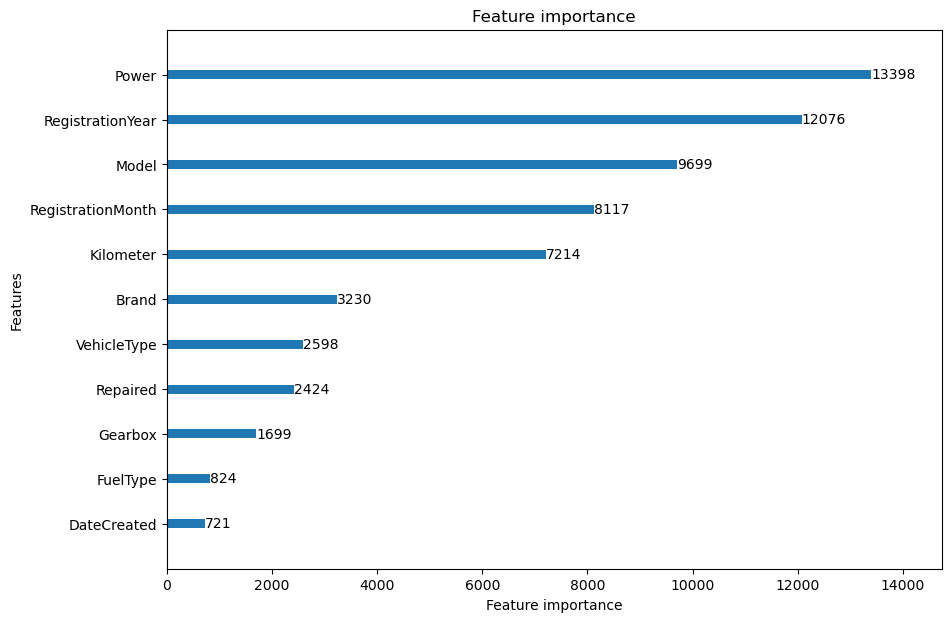

In [26]:
feature_names = X_train.columns
lgb.plot_importance(model_lgbm_optuna, figsize=(10,7), grid=False,)
plt.show()